## This notebook aims to visualize the different asset distributions produced by CGAN

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [ ]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [3]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [ ]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [5]:
from astrid_GAN import AstridGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = AstridGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

# Online training during the test period
# Assume test_returns_df contains daily returns for the test period
for test_day in test_returns_df.index:
    for asset_name in test_returns_df.columns:
        new_return = test_returns_df.loc[test_day, asset_name]
        gan = gan_dict[asset_name]
        
        # Process the new return (online_training handles fine-tuning or full retraining as needed)
        gan.online_training(new_return)
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        # Generate scenarios with the updated GAN
        scenarios = gan.generate_scenarios(num_scenarios=10000)
        
        # Store the generated scenarios for this test day
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")

# At this point, scenarios_results contains the generated scenario distribution for each asset keyed by date.


Training GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

Training GAN for REEL...
[Epoch 0/100] [Batch 0/16] [D loss: 0.00039552152156829834] [G loss: 0.18704134225845337]
[Epoch 0/100] [Batch 10/16] [D loss: -0.0546097457408905] [G loss: 0.43043336272239685]
[Epoch 1/100] [Batch 0/16] [D loss: -0.1002817451953888] [G loss: 0.3414075970649719]
[Epoch 1/100] [Batch 10/16] [D loss: 0.10204216837882996] [G loss: 0.3054582178592682]
[Epoch 2/100] [Batch 0/16] [D loss: 0.20383328199386597] [G loss: 0.32640379667282104]
[Epoch 2/100] [Batch 10/16] [D loss: -0.13099725544452667] [G loss: 0.16992130875587463]
[Epoch 3/100] [Batch 0/16] [D loss: 0.25005844235420227] [G loss: 0.3827037811279297]
[Epoch 3/100] [Batch 10/16] [D loss: 0.047857850790023804] [G loss: 0.3341682553291321]
[Epoch 4/100] [Batch 0/16] [D loss: 0.06175965070724487] [G loss: 0.4870184361934662]
[Epoch 4/100] [Batch 10/16] [D loss: 0.08119755983352661] [G loss: 0.2782954275608063]
[Epoch 5/100] [Batch 0/16] [D loss: 0.01790916919708252] [G loss: 0.4875473082065582]
[Epoch 5/100] [

Training GANs:  50%|█████     | 1/2 [00:35<00:35, 35.13s/asset]

REEL: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for PE...
[Epoch 0/100] [Batch 0/16] [D loss: 0.1521834135055542] [G loss: -0.1928466558456421]
[Epoch 0/100] [Batch 10/16] [D loss: 0.22026297450065613] [G loss: -0.18342414498329163]
[Epoch 1/100] [Batch 0/16] [D loss: 0.06161193549633026] [G loss: -0.09628722071647644]
[Epoch 1/100] [Batch 10/16] [D loss: -0.23016734421253204] [G loss: -0.2062191516160965]
[Epoch 2/100] [Batch 0/16] [D loss: 0.16272315382957458] [G loss: -0.03227527439594269]
[Epoch 2/100] [Batch 10/16] [D loss: 0.07459127902984619] [G loss: -0.129243403673172]
[Epoch 3/100] [Batch 0/16] [D loss: -0.04179331660270691] [G loss: -0.2532590627670288]
[Epoch 3/100] [Batch 10/16] [D loss: -0.14911270141601562] [G loss: -0.3993813395500183]
[Epoch 4/100] [Batch 0/16] [D loss: -0.25672945380210876] [G loss: -0.12762990593910217]
[Epoch 4/100] [Batch 10/16] [D loss: -0.007669180631637573] [G loss: -0.12264843285083771]
[Epoch 5/100] [Batch 0/16] 

Training GANs: 100%|██████████| 2/2 [01:09<00:00, 34.70s/asset]

PE: Stored initial generated scenarios for 2019-12-31 00:00:00.
REEL: Online fine-tuning update completed for new return 0.0048936249211004.
REEL: Processed online update for new return on 2020-01-02 00:00:00.
REEL: Stored generated scenarios for 2020-01-02 00:00:00.
PE: Online fine-tuning update completed for new return 0.0066035017774115.
PE: Processed online update for new return on 2020-01-02 00:00:00.


PE: Stored generated scenarios for 2020-01-02 00:00:00.
REEL: Online fine-tuning update completed for new return 0.0027563477284147.
REEL: Processed online update for new return on 2020-01-03 00:00:00.
REEL: Stored generated scenarios for 2020-01-03 00:00:00.
PE: Online fine-tuning update completed for new return -0.000132921471718.
PE: Processed online update for new return on 2020-01-03 00:00:00.
PE: Stored generated scenarios for 2020-01-03 00:00:00.
REEL: Online fine-tuning update completed for new return -0.0070930086884748.
REEL: Processed online update for new return on 2020-01-06 00:00:00.
REEL: Stored generated scenarios for 2020-01-06 00:00:00.
PE: Online fine-tuning update completed for new return -0.0037275567855377.
PE: Processed online update for new return on 2020-01-06 00:00:00.
PE: Stored generated scenarios for 2020-01-06 00:00:00.
REEL: Online fine-tuning update completed for new return 0.0040153041722794.
REEL: Processed online update for new return on 2020-01-07 00

In [23]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

In [ ]:
asset_names = list(returns_df.columns)
weights = [0.5, 0.5]  # for example; ensure len(portfolio_weights) == len(asset_names)

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

for date in all_dates:
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = asset_scenarios[:, -1]
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.
    portfolio = SimpleGANPortfolio(gan_samples, weights)
    _, scr = portfolio.calculate_distribution_and_scr()
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


Date 2019-12-31 00:00:00: SCR = -13497.645435041339
Date 2020-01-02 00:00:00: SCR = -12833.621143817305
Date 2020-01-03 00:00:00: SCR = -13637.602950276285
Date 2020-01-06 00:00:00: SCR = -13211.84825282827
Date 2020-01-07 00:00:00: SCR = -13351.102312030793
Date 2020-01-08 00:00:00: SCR = -13856.696134591102
Date 2020-01-09 00:00:00: SCR = -13632.314649933129
Date 2020-01-10 00:00:00: SCR = -13181.452715014368
Date 2020-01-13 00:00:00: SCR = -14085.824911783784
Date 2020-01-14 00:00:00: SCR = -13462.791580613703
Date 2020-01-15 00:00:00: SCR = -13397.287716997414
Date 2020-01-16 00:00:00: SCR = -14351.57800626277
Date 2020-01-17 00:00:00: SCR = -12955.566779556199
Date 2020-01-20 00:00:00: SCR = -13294.913853885233
Date 2020-01-21 00:00:00: SCR = -13791.01624520041
Date 2020-01-22 00:00:00: SCR = -13871.88651722446
Date 2020-01-23 00:00:00: SCR = -14244.680712934804
Date 2020-01-24 00:00:00: SCR = -14305.083142016754
Date 2020-01-27 00:00:00: SCR = -12908.377529609497
Date 2020-01-28 

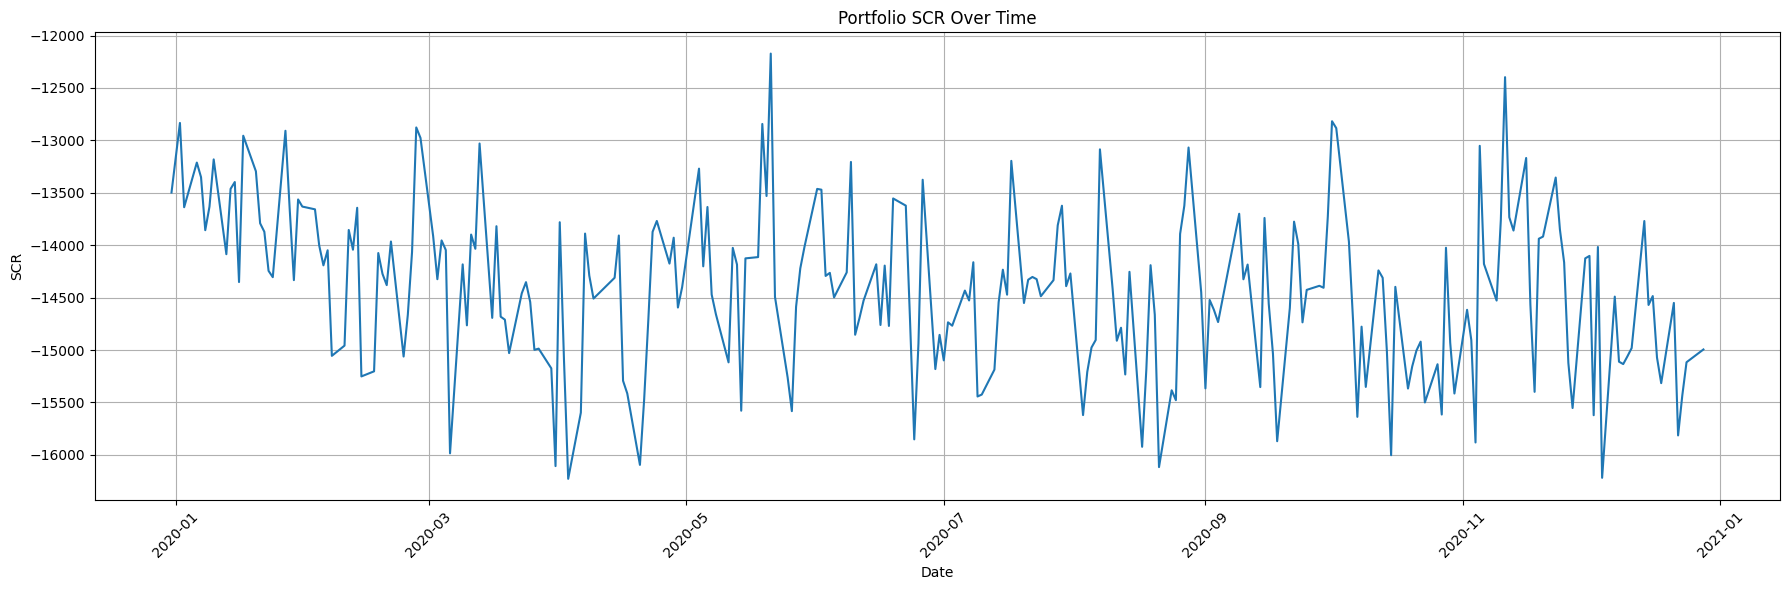

In [28]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## We need to get rolling Delta BOF

In [31]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,REEL,PE
Date,,
2020-12-21,-0.021011,-0.009039
2020-12-22,0.010600,0.007414
2020-12-23,0.021998,0.011317
2020-12-24,0.004674,0.002335
2020-12-28,0.000842,0.000271


In [ ]:
# CALCULATE DELTA BOF ARRAY

eonia = entire_df.iloc[:, -1]

portfolio_returns = (entire_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

bof_0 = assets_0 - liabilities_0

delta_bof = bof - bof_0 # Delta BOF


In [ ]:
# Suppose delta_bof is a pandas Series with a datetime index:
# For example:
# delta_bof = pd.Series(data_array, index=date_index)

# 1. Transform the daily delta_bof to a rolling 252-day basis.
#    Here, we compute the rolling sum over 252 days.
rolling_delta_bof = delta_bof.rolling(window=252).sum()

# 2. Determine the test period.
# Assume that returns_df contains historical data and test_returns_df contains the test period.
# Let test_start be the first date in test_returns_df.
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
rolling_test = rolling_delta_bof.loc[test_start_date:test_end_date]

# Option B: If you instead want to calculate the cumulative delta_bof (running sum)
# over the test period (starting at test_start), do this:
delta_bof_test = delta_bof.loc[test_start_date:test_end_date]
cumulative_delta_bof_test = delta_bof_test.cumsum()

# 3. Plot the cumulative delta_bof over the test period.
plt.figure(figsize=(10, 6))
plt.plot(cumulative_delta_bof_test.index, cumulative_delta_bof_test.values, marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Cumulative delta BOF")
plt.title("Cumulative Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Scaled = False


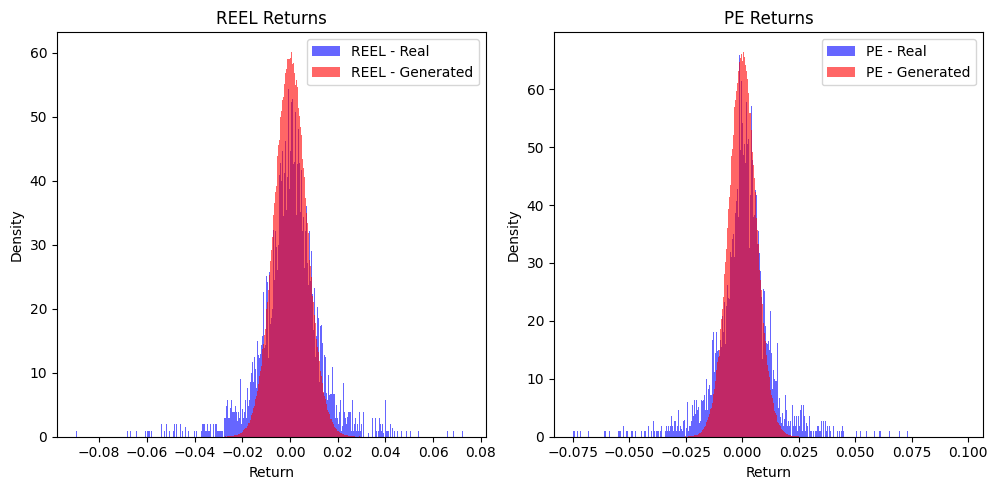


📊 Return Statistics Summary:
           Asset     Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
     REEL - Real 0.000193 0.012916 -0.270455  4.969021  -0.051644
REEL - Generated 0.000216 0.006806  0.026405  0.124220  -0.017467
       PE - Real 0.000224 0.012736 -0.303648  6.380382  -0.052287
  PE - Generated 0.000119 0.006160  0.017939  0.115772  -0.015927



═══════════════════════════
║  ANALYZING ASSET: REEL  ║
═══════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Variance of Real Data: 0.000167
Variance of Generated Data: 0.000032
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.276380
Mean Pairwise Distance (Generated): 0.126853
⚠️ Warning: Potential Mode Collapse - Samples are too similar


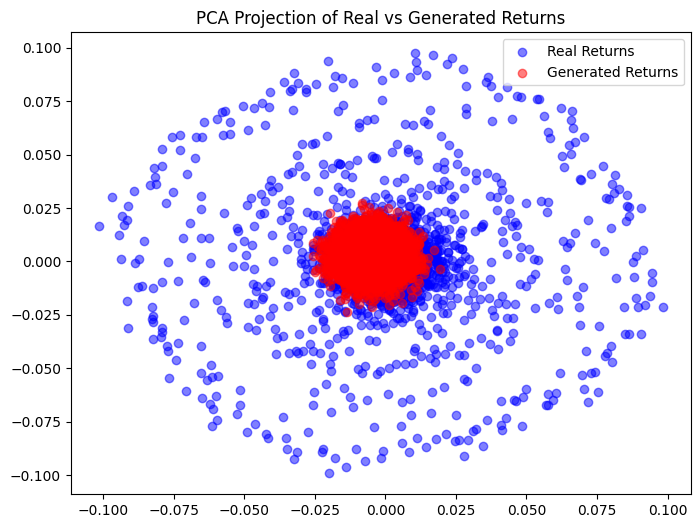

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt


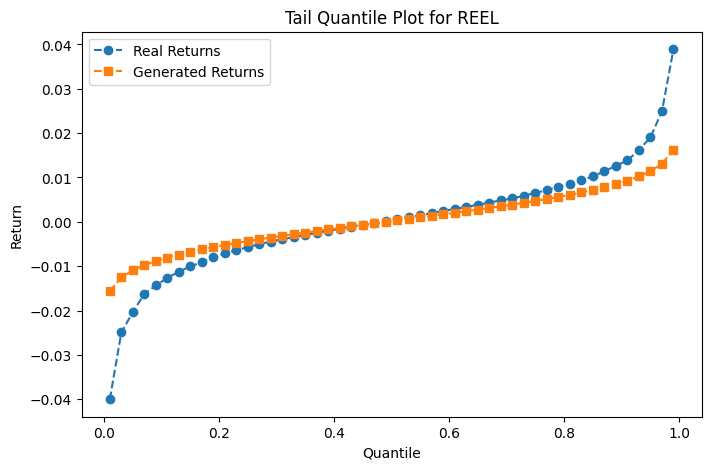


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 0.405095
Mean Distance: 0.001181
Median Distance: 0.000379
Standard Deviation: 0.003495


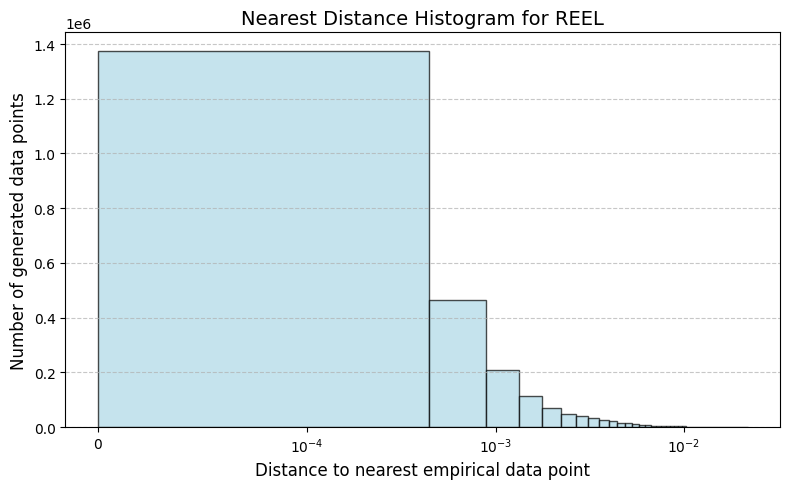


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.003484


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000028
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.117324
⚠️ Warning: Potential Mode Collapse - Samples are too similar


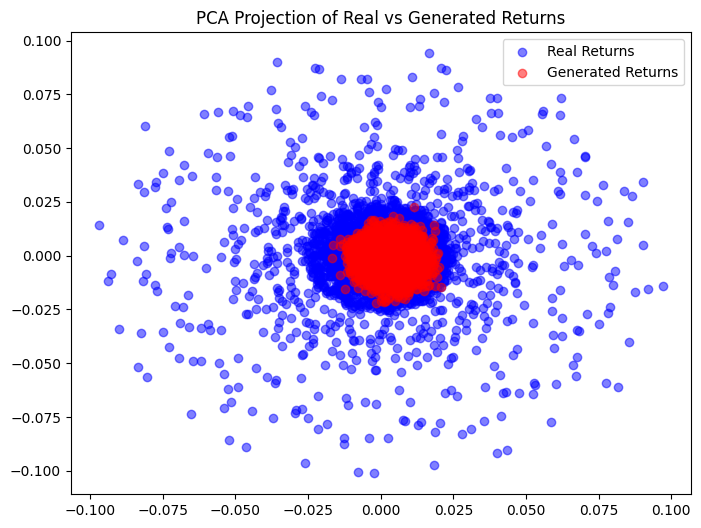

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt


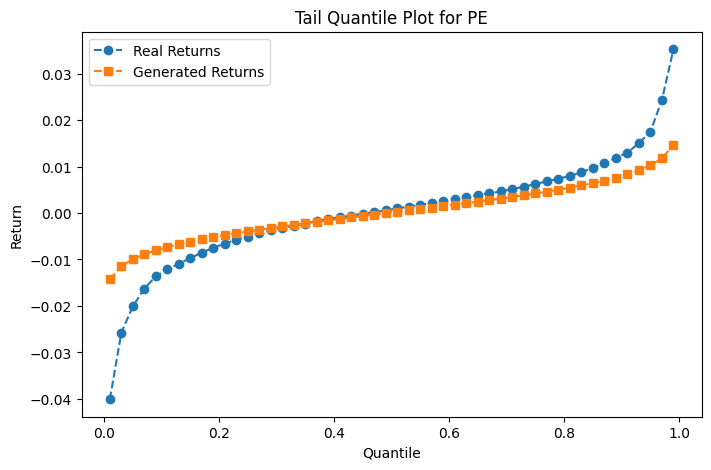


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 0.235945
Mean Distance: 0.001255
Median Distance: 0.000385
Standard Deviation: 0.003677


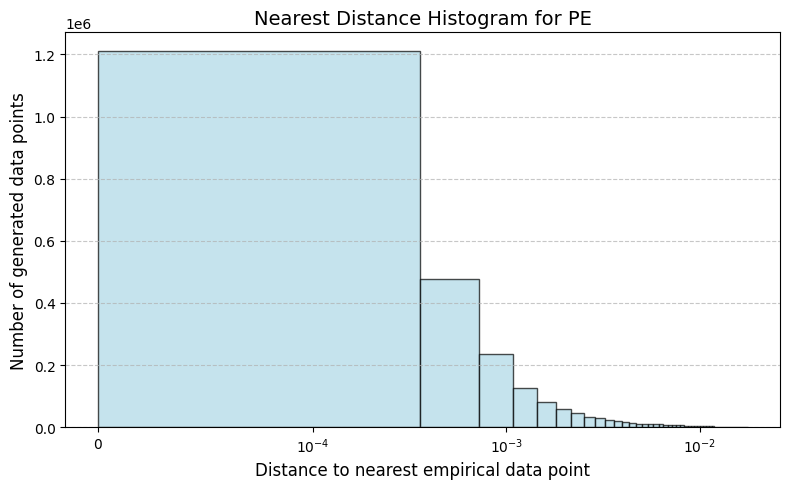


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.003720



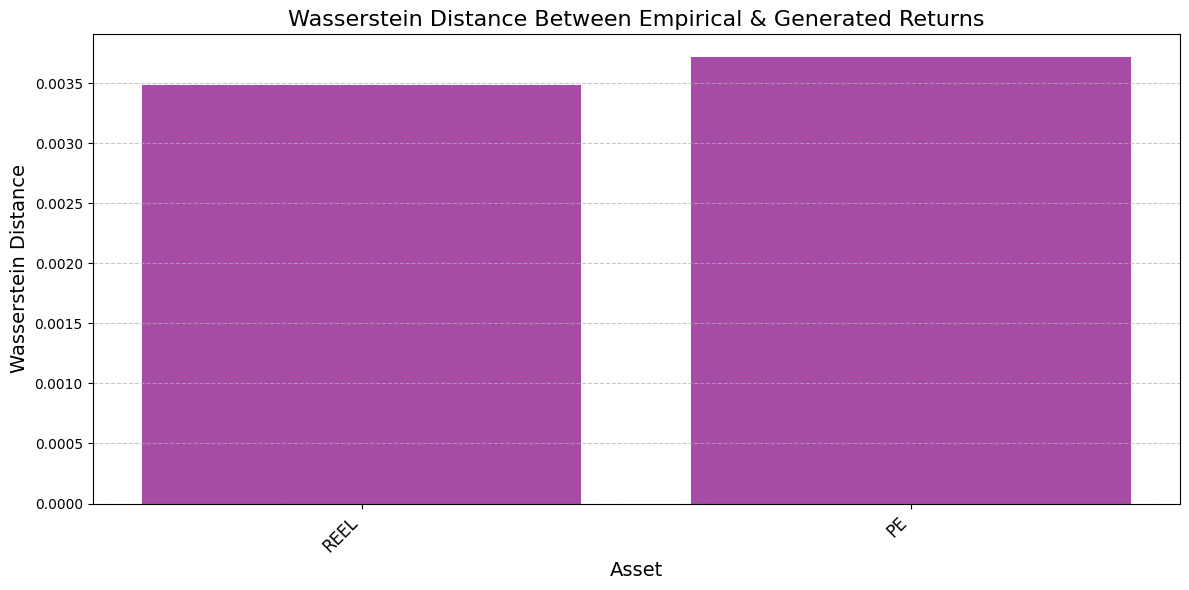

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=False, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'